# 可转债    多因子回归模型

### 标准化（打分/zscore）后回归（OLS/XGBoost）

### 因子来源：数立方提取 + 民生研报23/08/02--可转债股债性 + 东方研报23/07/01--可转债多因子模型初探

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import dcube as dc
import matplotlib.pyplot as plt
pro = dc.pro_api('')
from itertools import combinations
%run Quant_useful_packages_ccb.ipynb

df_con_value = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__conv_value.csv',index_col=0)
df_strb_value = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__strbvalue.csv',index_col=0)
df_ccb_pctchg = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__pctchange.csv',index_col=0)
df_stock_close = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__EODP__S_DQ_CLOSE.csv',index_col=0)
df_BS_option_price_per_stock = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__BS_price.csv',index_col=0)
df_ccb_conv_ratio = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__conv_ratio.csv',index_col=0)
df_ccb_strb_price = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__strbvalue.csv',index_col=0)
df_ccb_close = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__close.csv',index_col=0)
df_stock_pctchg = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__EODP__S_DQ_PCTCHANGE.csv',index_col=0)
df_stock_high = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__EODP__S_DQ_HIGH.csv',index_col=0)
df_stock_low = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__EODP__S_DQ_LOW.csv',index_col=0)
df_ccb_high = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__high.csv',index_col=0)
df_ccb_low = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__low.csv',index_col=0)
df_ccb_convpremium_ratio = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__convpremium_ratio.csv',index_col=0)
df_stock_mv = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__EODDI__S_VAL_MV.csv',index_col=0)
df_stock_roe = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__s_qfa_roe_deducted_diff4q_8qzscore.csv',index_col=0)
df_stock_corr = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__PCTcorrQZ_20d.csv',index_col=0)
df_stock_beta = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__betaQADQ_20d.csv',index_col=0)
df_BS_iv = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__BS_iv.csv',index_col=0)
df_BS_iv_bias = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__BS_iv_bias.csv',index_col=0)
df_ccb_outstanding_balance = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__outstanding_balance.csv',index_col=0)
df_ccb_turn = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__TR20DDIVTR60D.csv',index_col=0)
df_ccb_amount = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__amount.csv',index_col=0)
df_stock_dl1 = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__dp_df52cs_p5dNBr-18-23.csv',index_col=0)
df_stock_dl2 = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__dp_df62l2pv9cs_p5dNBr-18-23.csv',index_col=0)


### 根据平底溢价率划分偏股、平衡、偏债型转债

In [5]:
df_par_value = df_con_value/df_strb_value - 1
df_ccb_class = df_par_value.copy()
for code in df_con_value.columns:   # 1偏股，2平衡，3偏债
    df_ccb_class[code] = np.where(df_ccb_class[code]>0.2, 1,
                                  np.where(df_ccb_class[code]>=-0.2, 2,
                                          np.where(df_ccb_class[code]<-0.2, 3, df_ccb_class[code])))
# df_ccb_class

In [6]:
# 每天每组转债个数
a=df_ccb_class.replace(np.nan,0)
for i in df_ccb_class.index:
    print(i,sum(a.loc[i,:]==1),sum(a.loc[i,:]==2),sum(a.loc[i,:]==3))

2016-01-04 2 13 12
2016-01-05 2 13 13
2016-01-06 2 14 12
2016-01-07 1 13 14
2016-01-08 1 13 14
2016-01-11 1 10 17
2016-01-12 1 11 16
2016-01-13 1 9 18
2016-01-14 1 10 17
2016-01-15 1 8 21
2016-01-18 1 7 22
2016-01-19 1 8 21
2016-01-20 1 7 22
2016-01-21 1 7 22
2016-01-22 1 10 21
2016-01-25 1 10 21
2016-01-26 1 9 22
2016-01-27 1 7 24
2016-01-28 1 5 26
2016-01-29 1 6 25
2016-02-01 1 5 26
2016-02-02 1 6 26
2016-02-03 1 7 25
2016-02-04 1 8 24
2016-02-05 1 8 24
2016-02-15 1 7 25
2016-02-16 1 8 24
2016-02-17 1 9 23
2016-02-18 1 9 23
2016-02-19 1 8 24
2016-02-22 1 11 21
2016-02-23 1 11 21
2016-02-24 1 11 21
2016-02-25 0 8 25
2016-02-26 0 11 24
2016-02-29 0 9 26
2016-03-01 0 11 24
2016-03-02 0 14 22
2016-03-03 0 14 22
2016-03-04 0 11 25
2016-03-07 0 12 24
2016-03-08 0 12 24
2016-03-09 0 13 23
2016-03-10 0 11 25
2016-03-11 0 13 23
2016-03-14 0 15 22
2016-03-15 0 14 23
2016-03-16 0 14 23
2016-03-17 0 14 23
2016-03-18 1 18 19
2016-03-21 1 18 19
2016-03-22 1 18 19
2016-03-23 1 18 19
2016-03-24 1 17

2017-11-16 29 53 86
2017-11-17 27 54 88
2017-11-20 30 54 85
2017-11-21 30 52 87
2017-11-22 30 52 87
2017-11-23 25 54 90
2017-11-24 26 58 87
2017-11-27 22 59 89
2017-11-28 27 58 87
2017-11-29 26 62 85
2017-11-30 25 60 88
2017-12-01 28 61 85
2017-12-04 27 61 87
2017-12-05 26 58 92
2017-12-06 28 60 92
2017-12-07 24 65 93
2017-12-08 24 67 92
2017-12-11 25 66 91
2017-12-12 25 66 91
2017-12-13 26 67 91
2017-12-14 26 66 92
2017-12-15 27 65 94
2017-12-18 27 66 94
2017-12-19 29 65 94
2017-12-20 27 65 98
2017-12-21 30 65 96
2017-12-22 34 62 98
2017-12-25 34 61 100
2017-12-26 37 58 100
2017-12-27 34 64 100
2017-12-28 37 65 96
2017-12-29 39 67 93
2018-01-02 43 65 91
2018-01-03 47 61 91
2018-01-04 47 61 91
2018-01-05 46 63 90
2018-01-08 46 64 89
2018-01-09 44 66 89
2018-01-10 41 68 90
2018-01-11 46 61 92
2018-01-12 42 66 91
2018-01-15 36 64 99
2018-01-16 36 63 101
2018-01-17 37 66 98
2018-01-18 39 66 96
2018-01-19 42 66 94
2018-01-22 44 64 95
2018-01-23 45 62 96
2018-01-24 46 64 93
2018-01-25 46 65

2019-10-11 56 133 134
2019-10-14 61 134 129
2019-10-15 60 130 133
2019-10-16 59 132 132
2019-10-17 56 138 129
2019-10-18 52 139 133
2019-10-21 52 142 132
2019-10-22 54 141 131
2019-10-23 56 137 134
2019-10-24 53 142 133
2019-10-25 55 140 132
2019-10-28 63 139 128
2019-10-29 58 141 132
2019-10-30 51 144 135
2019-10-31 52 142 137
2019-11-01 56 142 134
2019-11-04 57 145 131
2019-11-05 59 143 131
2019-11-06 56 144 133
2019-11-07 57 142 134
2019-11-08 57 142 134
2019-11-11 55 142 137
2019-11-12 53 142 139
2019-11-13 52 142 140
2019-11-14 53 144 138
2019-11-15 51 145 140
2019-11-18 54 146 138
2019-11-19 56 144 137
2019-11-20 54 146 137
2019-11-21 51 147 138
2019-11-22 46 151 138
2019-11-25 44 152 139
2019-11-26 41 159 135
2019-11-27 44 156 136
2019-11-28 42 155 139
2019-11-29 45 153 138
2019-12-02 47 152 141
2019-12-03 48 153 139
2019-12-04 51 150 140
2019-12-05 54 153 133
2019-12-06 56 151 133
2019-12-09 57 149 134
2019-12-10 59 149 132
2019-12-11 57 152 132
2019-12-12 59 153 130
2019-12-13

2021-04-22 124 249 110
2021-04-23 122 250 112
2021-04-26 127 239 119
2021-04-27 125 240 120
2021-04-28 128 241 117
2021-04-29 128 240 118
2021-04-30 119 249 118
2021-05-06 120 249 117
2021-05-07 120 246 120
2021-05-10 125 241 120
2021-05-11 122 245 119
2021-05-12 128 243 115
2021-05-13 121 240 125
2021-05-14 125 242 119
2021-05-17 123 246 117
2021-05-18 126 238 123
2021-05-19 128 232 126
2021-05-20 124 235 127
2021-05-21 123 235 128
2021-05-24 122 238 126
2021-05-25 125 238 124
2021-05-26 131 234 123
2021-05-27 133 237 118
2021-05-28 131 237 120
2021-05-31 134 232 121
2021-06-01 138 231 119
2021-06-02 135 231 122
2021-06-03 130 234 124
2021-06-04 132 234 123
2021-06-07 130 239 121
2021-06-08 134 240 117
2021-06-09 139 241 114
2021-06-10 141 242 112
2021-06-11 138 247 111
2021-06-15 137 247 112
2021-06-16 130 248 118
2021-06-17 130 247 119
2021-06-18 134 251 110
2021-06-21 143 244 109
2021-06-22 144 245 107
2021-06-23 150 240 106
2021-06-24 151 238 107
2021-06-25 152 237 107
2021-06-28 

2022-11-14 113 257 189
2022-11-15 126 254 179
2022-11-16 124 253 182
2022-11-17 125 258 178
2022-11-18 123 254 184
2022-11-21 121 255 185
2022-11-22 115 259 188
2022-11-23 111 258 195
2022-11-24 117 255 195
2022-11-25 108 263 197
2022-11-28 106 265 198
2022-11-29 113 271 185
2022-11-30 110 275 183
2022-12-01 120 269 177
2022-12-02 126 264 177
2022-12-05 126 269 175
2022-12-06 124 270 176
2022-12-07 120 275 175
2022-12-08 117 279 174
2022-12-09 117 280 173
2022-12-12 114 281 174
2022-12-13 116 280 174
2022-12-14 119 282 170
2022-12-15 120 279 175
2022-12-16 114 280 181
2022-12-19 108 271 197
2022-12-20 103 271 202
2022-12-21 102 269 207
2022-12-22 91 268 217
2022-12-23 87 271 218
2022-12-26 97 271 207
2022-12-27 101 266 208
2022-12-28 95 266 214
2022-12-29 96 266 214
2022-12-30 98 267 214
2023-01-03 108 271 201
2023-01-04 106 272 203
2023-01-05 116 267 198
2023-01-06 116 263 202
2023-01-09 116 265 198
2023-01-10 117 266 196
2023-01-11 117 260 202
2023-01-12 117 261 202
2023-01-13 115 26

### 民生研报23/08/02因子计算

In [7]:
# 1.偏股型转债

# 转债收益率因子
factor_ret60 =df_ccb_pctchg.rolling(60,min_periods=30).mean()
# 正股波动率因子
factor_stock_std = df_stock_close.rolling(21,min_periods=10).std()
# BS定价偏差因子
df_BS_option_price = df_BS_option_price_per_stock * df_ccb_conv_ratio
df_BS_ccb_price = df_BS_option_price + df_ccb_strb_price
factor_deviation_BS = (df_BS_ccb_price - df_ccb_close) / df_ccb_close 


# 2.平衡型转债

# 正股收益率因子3
factor_stock_mean40 = df_stock_pctchg.rolling(40,min_periods=20).mean()
# 转债-正股振幅差2
df_stock_amplitude = (df_stock_high - df_stock_low) / df_stock_close.shift(1)
df_ccb_amplitude = (df_ccb_high - df_ccb_low) / df_ccb_close.shift(1)
df_dif_amplitude = df_stock_amplitude - df_ccb_amplitude
factor_dif_amplitude = df_dif_amplitude.rolling(20,min_periods=10).mean()


# 3.偏债型转债

# 双低因子
factor_dual_low = df_ccb_close + df_ccb_convpremium_ratio*100

### 东方研报23/07/01因子计算

In [8]:
# 正股动量类因子-RSI
##   df_ccb_positive_pct20 = pd.DataFrame(index=df_ccb_pctchg.index,columns=df_ccb_pctchg.columns)
##   for i in tqdm(range(20, len(df_ccb_pctchg))):
##       df_ccb_positive_pct20.iloc[i,] = df_ccb_pctchg.iloc[i-19:i+1,].apply(lambda x: x[x > 0].sum(), axis=0)
##   factor_stock_RSI = df_ccb_positive_pct20 / df_ccb_pctchg.abs().rolling(20,min_periods=10).sum().replace(0,np.nan)
# factor_stock_RSI

# 正股动量类因子-Percent B + Price To High
# 计算布林线下轨：20日的移动平均线 - 2倍标准差
df_bollinger_lower = df_ccb_close.rolling(20,min_periods=10).mean() - 2*df_ccb_close.rolling(20,min_periods=10).std()
df_bollinger_higher = df_ccb_close.rolling(20,min_periods=10).mean() + 2*df_ccb_close.rolling(20,min_periods=10).std()
factor_percentB = (df_ccb_close - df_bollinger_lower) / (df_bollinger_higher - df_bollinger_lower)

factor_price2high = df_ccb_close / df_ccb_high.rolling(20,min_periods=10).max()

# 正股量价结合因子-Amihud
factor_Amihud = (df_ccb_pctchg.abs() / df_ccb_amount).rolling(20,min_periods=10).mean()

# 转债量价因子-偏度
factor_skewness = df_ccb_pctchg.rolling(20,min_periods=10).skew()


In [ ]:


'''
23个因子

转债收益率因子 + 正股波动率因子 + BS定价偏差因子 + 正股收益率因子 + 转债-正股振幅差因子 + 双低因子 +
转股溢价率因子 + 转债收盘价 + 正股市值 + 隐含波动率 + 隐含波动率与正股240日波动率之差 + 债券余额 + 转债20日换手/60日换手 +
正股RSI + 正股percentB + 正股price2high + 正股Amihud + 转债收益率偏度 
'''

all_factors=[factor_ret60, factor_stock_std, factor_deviation_BS,factor_stock_mean40, factor_dif_amplitude, -factor_dual_low,
             -df_ccb_convpremium_ratio, -df_ccb_close, -df_stock_mv, -df_BS_iv, -df_BS_iv_bias, 
             -df_ccb_outstanding_balance, df_ccb_turn, -factor_stock_RSI, -factor_percentB, -factor_price2high, 
             -factor_Amihud, factor_skewness]

chen_factors=[-factor_dual_low,-df_ccb_close, -df_BS_iv, -df_BS_iv_bias, -df_ccb_outstanding_balance, df_ccb_turn,
                  -df_ccb_convpremium_ratio,-df_stock_mv,df_stock_roe,df_stock_corr,df_stock_beta,5*df_stock_dl1,5*df_stock_dl2]

other_factors=[factor_ret60, factor_stock_std, factor_deviation_BS,factor_stock_mean40, factor_dif_amplitude,
               -factor_stock_RSI, -factor_percentB, -factor_price2high, -factor_Amihud, factor_skewness]


In [ ]:
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [9]:
bonds_multdays_class0 = ccb_get_class_bonds_multdays(df_ccb_class,class_n=0,index_code='ZZZZ',start_date='20160101',end_date='20230626')
bbc_code_multdays = list(bonds_multdays_class0.values())
trade_days = list(bonds_multdays_class0.keys())


In [10]:
df_ccb_ret = df_ccb_pctchg.rolling(10).mean()
df_ccb_ret = df_ccb_ret.shift(-10)

df_ccb_ret_close = (df_ccb_close.shift(-6) - df_ccb_close.shift(-1)) / df_ccb_close.shift(-1)

In [11]:
selected_factors=[factor_ret60, factor_stock_std, factor_deviation_BS,factor_stock_mean40, factor_dif_amplitude, factor_dual_low,
                  df_stock_roe, df_stock_corr, df_stock_beta,
                  df_ccb_convpremium_ratio, df_ccb_close, df_stock_mv, df_BS_iv, df_BS_iv_bias, 
                  df_ccb_outstanding_balance, df_ccb_turn, factor_percentB, factor_price2high, 
                  factor_Amihud, factor_skewness, df_ccb_ret_close]

factor_names_all=['factor_ret60', 'factor_stock_std', 'factor_deviation_BS','factor_stock_mean40', 'factor_dif_amplitude', 
                  'factor_dual_low', 'df_stock_roe', 'df_stock_corr', 'df_stock_beta',
                  'df_ccb_convpremium_ratio', 'df_ccb_close', 'df_stock_mv', 'df_BS_iv', 'df_BS_iv_bias', 
                  'df_ccb_outstanding_balance', 'df_ccb_turn', 'factor_percentB', 'factor_price2high', 
                  'factor_Amihud', 'factor_skewness', 'df_ccb_ret_close']

selected_factors = [factor_ret60,factor_stock_std,factor_deviation_BS,factor_stock_mean40,factor_dif_amplitude,factor_dual_low,
                    df_ccb_convpremium_ratio,df_stock_mv,
                   df_ccb_ret_close]
factor_names_all = ['factor_ret60','factor_stock_std','factor_deviation_BS','factor_stock_mean40','factor_dif_amplitude',
                    'factor_dual_low','df_ccb_convpremium_ratio','df_stock_mv','df_ccb_ret_close']

### 排序打分

In [117]:


dict_factors = {}
for date,code_list in tqdm(zip(trade_days,bbc_code_multdays),total=len(trade_days)):
    df_factors = pd.DataFrame()
    date_str = date.strftime('%Y-%m-%d')
    for factor,factor_name in zip(selected_factors,factor_names_all):
        df_factors[factor_name] = factor.loc[date_str,code_list]
    df_factors = df_factors.rank(pct=True,axis=0)
    average_rank = df_factors.mean()
    df_factors = df_factors.fillna(average_rank)
    df_factors['date'] = date
    dict_factors[date] = df_factors


100%|██████████████████████████████████████████████████████████████████████████████| 1817/1817 [00:24<00:00, 74.53it/s]


### z-score打分

In [123]:

dict_factors = {}
for date,code_list in tqdm(zip(trade_days,bbc_code_multdays),total=len(trade_days)):
    df_factors = pd.DataFrame()
    date_str = date.strftime('%Y-%m-%d')
    for factor,factor_name in zip(selected_factors,factor_names_all):
        df_factors[factor_name] = factor.loc[date_str,code_list]
    df_factors = (df_factors - df_factors.mean()) / df_factors.std()
    average_score = df_factors.mean()
    df_factors = df_factors.fillna(average_score)
    df_factors['date'] = date
    dict_factors[date] = df_factors
    


100%|██████████████████████████████████████████████████████████████████████████████| 1817/1817 [00:31<00:00, 57.38it/s]


### 不标准化，后续预测绝对收益

In [12]:
dict_factors = {}
for date,code_list in tqdm(zip(trade_days,bbc_code_multdays),total=len(trade_days)):
    df_factors = pd.DataFrame()
    date_str = date.strftime('%Y-%m-%d')
    for factor,factor_name in zip(selected_factors,factor_names_all):
        df_factors[factor_name] = factor.loc[date_str,code_list]
    df_factors['date'] = date
    dict_factors[date] = df_factors


100%|██████████████████████████████████████████████████████████████████████████████| 1817/1817 [00:20<00:00, 88.62it/s]


In [16]:
df_factors

,factor_ret60,factor_stock_std,factor_deviation_BS,factor_stock_mean40,factor_dif_amplitude,factor_dual_low,df_ccb_convpremium_ratio,df_stock_mv,df_ccb_ret_close,date
110043.SH,-0.054500,0.098455,0.028005,-0.185895,0.005555,1950.899,18.4257,1.107824e+06,NaN,2023-06-26
110044.SH,-0.058667,0.375907,-0.102097,-0.134608,0.011222,13774.033,135.7106,4.184902e+05,NaN,2023-06-26
110045.SH,0.009167,0.229030,0.726574,0.162163,0.018785,1889.790,17.6844,2.717033e+06,NaN,2023-06-26
110047.SH,-0.090667,0.019724,0.199208,-0.116597,0.011522,2290.407,21.7635,9.924655e+05,NaN,2023-06-26
110048.SH,-0.082000,0.528589,0.332707,-0.173212,0.001390,2037.241,18.5721,2.267300e+06,NaN,2023-06-26
110052.SH,-0.285167,0.359641,0.491797,-0.324542,0.012985,2020.792,18.7778,1.154416e+06,NaN,2023-06-26
110053.SH,0.031833,0.100273,0.141102,-0.056750,0.003472,420.902,2.9655,1.064894e+07,NaN,2023-06-26
110055.SH,0.031333,0.744134,0.330958,0.448277,0.002112,2376.706,21.6780,1.296484e+06,NaN,2023-06-26
110058.SH,0.838500,0.819369,0.263721,0.007255,-0.011674,3861.083,36.6960,9.915974e+05,NaN,2023-06-26
110059.SH,0.027500,0.095912,0.484968,-0.104557,0.012795,10542.580,104.3468,2.101616e+07,NaN,2023-06-26


### 划分训练集、测试集

In [13]:

# 按年划分

# 划分数据集为样本内和样本外
def split_dataset(dict_factors,current_date,list_X,Y,list_ID):
    sample_in_start=datetime.date(current_date.year-1,current_date.month,current_date.day)
    sample_in_end=current_date-datetime.timedelta(days=1)
    sample_out_start=current_date
    sample_out_end=datetime.date(current_date.year+1,current_date.month,current_date.day)
    sample_in_data=[]
    sample_out_data=[]
    
    for date,df in dict_factors.items():
        if (date>=sample_in_start) & (date<=sample_in_end):
            sample_in_data.append(df)
        if (date>=sample_out_start) & (date<=sample_out_end):
            sample_out_data.append(df)
            
    sample_in_data = pd.concat(sample_in_data,axis=0).reset_index(drop=False).rename(columns={'index':'code'}).dropna()    
    sample_out_data = pd.concat(sample_out_data,axis=0).reset_index(drop=False).rename(columns={'index':'code'}).dropna()
    sample_in_X=sample_in_data[list_X]
    sample_in_Y=sample_in_data[Y]
    sample_out_X=sample_out_data[list_X]
    sample_out_Y=sample_out_data[Y]
    ID_out=sample_out_data[list_ID]
    
    return sample_in_X,sample_in_Y,sample_out_X,sample_out_Y,ID_out

# 根据滚动窗口划分数据集
def generate_rolling_datasets(dict_factors,start_date,end_date,list_X,Y,list_ID):
    X_in_all=[]
    Y_in_all=[]
    X_out_all=[]
    Y_out_all=[]
    ID_out_all=[]
    while start_date<=end_date:
        sample_in_X,sample_in_Y,sample_out_X,sample_out_Y,ID_out=split_dataset(dict_factors,start_date,list_X,Y,list_ID)
        X_in_all.append(sample_in_X)
        Y_in_all.append(sample_in_Y)
        X_out_all.append(sample_out_X)
        Y_out_all.append(sample_out_Y)
        ID_out_all.append(ID_out)
        start_date=datetime.date(start_date.year+1,start_date.month,start_date.day)
    return X_in_all,Y_in_all,X_out_all,Y_out_all,ID_out_all


### OLS回归

In [ ]:

from sklearn.linear_model import LinearRegression
def predict(X_in_all,Y_in_all,X_out_all,Y_out_all,ID_out_all):
    ID_out_list=[]
    for X_in,Y_in,X_out,Y_out,ID_out in tqdm(zip(X_in_all,Y_in_all,X_out_all,Y_out_all,ID_out_all),total=len(X_in_all)):
        model = LinearRegression()
        model.fit(X_in,Y_in)
        yhat = model.predict(X_out)
                
        ID_out['y'] = Y_out
        ID_out['yhat'] = yhat
        ID_out_list.append(ID_out)

    return ID_out_list


In [ ]:
# 打分-回归

# 生成滚动划分的数据集
X_in_all,Y_in_all,X_out_all,Y_out_all,ID_out_all=generate_rolling_datasets(dict_factors,datetime.date(2017,1,1),datetime.date(2023,1,1),
                list_X=factor_names_all[:-1],Y='df_ccb_ret_close',
                list_ID=['date','code'])

ID_out_list=predict(X_in_all,Y_in_all,X_out_all,Y_out_all,ID_out_all)

In [ ]:
# 打分-回归
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=0,index_pool='ZZZZ',start_date='20170103',end_date='20230620',factor_name='try',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

### XGBoost回归 + 网格搜索

In [14]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import time

def xgb_predict(X_in_all,Y_in_all,X_out_all,Y_out_all,ID_out_all):
    ID_out_list = []
    for X_train, X_test, y_train, y_test, ID_out in tqdm(zip(X_in_all,X_out_all,Y_in_all,Y_out_all,ID_out_all),total=len(X_in_all)):
        param_grid = {
            'learning_rate': [0.01,0.025,0.04],
            'reg_alpha': [0, 0.001, 0.01],
            'reg_lambda': [ 0.001, 0.01]
        }

        xgb_model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100,max_depth=3)        
        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
        grid_search.fit(X_train, y_train)

        print("Best parameters found: ", grid_search.best_params_)
        print("Best RMSE score: ", np.sqrt(-grid_search.best_score_))

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        print("Test RMSE: ", np.sqrt(mse))
        
        ID_out['y'] = y_test
        ID_out['yhat'] = y_pred
        ID_out_list.append(ID_out)
    return ID_out_list


In [15]:
X_in_all,Y_in_all,X_out_all,Y_out_all,ID_out_all=generate_rolling_datasets(dict_factors,datetime.date(2020,1,1),datetime.date(2023,1,1),
                list_X=factor_names_all[:-1],Y='df_ccb_ret_close',
                list_ID=['date','code'])

ID_out_list = xgb_predict(X_in_all,Y_in_all,X_out_all,Y_out_all,ID_out_all)

 25%|█████████████████████                                                               | 1/4 [01:04<03:14, 64.70s/it]

Best parameters found:  {'learning_rate': 0.04, 'reg_alpha': 0.01, 'reg_lambda': 0.001}
Best RMSE score:  0.03685482897782194
Test RMSE:  0.06795912952970527


 50%|██████████████████████████████████████████                                          | 2/4 [02:45<02:51, 85.88s/it]

Best parameters found:  {'learning_rate': 0.04, 'reg_alpha': 0, 'reg_lambda': 0.01}
Best RMSE score:  0.06654500046059574
Test RMSE:  0.05294369868547469


 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [05:06<01:51, 111.17s/it]

Best parameters found:  {'learning_rate': 0.04, 'reg_alpha': 0.01, 'reg_lambda': 0.001}
Best RMSE score:  0.05305167192517849
Test RMSE:  0.048657650037205555


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [08:04<00:00, 121.05s/it]

Best parameters found:  {'learning_rate': 0.04, 'reg_alpha': 0.001, 'reg_lambda': 0.001}
Best RMSE score:  0.04759794241617706
Test RMSE:  0.033879479488122415


In [ ]:
# 不网格搜索，直接参数赋值
def xgb_predict(X_in_all,Y_in_all,X_out_all,Y_out_all,ID_out_all):
    ID_out_list = []
    for X_train, X_test, y_train, y_test, ID_out in tqdm(zip(X_in_all,X_out_all,Y_in_all,Y_out_all,ID_out_all),total=len(X_in_all)):
        model = xgb.XGBRegressor(max_depth=3,          # 每一棵树最大深度，默认6；
                        learning_rate=0.025,      # 学习率，每棵树的预测结果都要乘以这个学习率，默认0.3；
                        n_estimators=100,        # 使用多少棵树来拟合，也可以理解为多少次迭代。默认100；
                        objective='reg:squarederror',   
                        booster='gbtree',         # 有两种模型可以选择gbtree和gblinear。gbtree使用基于树的模型进行提升计算，gblinear使用线性模型进行提升计算。默认为gbtree
                        gamma=0,                 # 叶节点上进行进一步分裂所需的最小"损失减少"。默认0；
                        min_child_weight=1,      # 可以理解为叶子节点最小样本数，默认1；
                        subsample=0.95,              # 训练集抽样比例，每次拟合一棵树之前，都会进行该抽样步骤。默认1，取值范围(0, 1]
                        colsample_bytree=1,       # 每次拟合一棵树之前，决定使用多少个特征，参数默认1，取值范围(0, 1]。
                        reg_alpha=0.001,             # 默认为0，控制模型复杂程度的权重值的 L1 正则项参数，参数值越大，模型越不容易过拟合。
                        reg_lambda=0.01,            # 默认为1，控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
                        random_state=0)           # 随机种子
        model.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse', verbose=50)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        print("Test RMSE: ", np.sqrt(mse))
        plot_importance(model)   # 特征重要性程度
        plt.show()

        
        ID_out['y'] = y_test
        ID_out['yhat'] = y_pred
        ID_out_list.append(ID_out)
    return ID_out_list
        

ID_out_list = xgb_predict(X_in_all,Y_in_all,X_out_all,Y_out_all,ID_out_all)

In [ ]:
# 打分-回归
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=0,index_pool='ZZZZ',start_date='20170103',end_date='20230620',factor_name='try',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

### 预测结果因子生成

In [125]:
trade_day = factor_ret60.index[(factor_ret60.index>='2020-01-01') & (factor_ret60.index<='2023-06-26')]
trade_day = pd.to_datetime(trade_day).date
factor = pd.concat(ID_out_list,axis=0)
factor = factor.pivot(index='date',columns='code',values='yhat')
factor = factor.reindex(index=trade_day)
factor = factor.rank(pct=True,axis=0)
factor = factor.rolling(10,min_periods=3).mean()
factor

code,110031.SH,110033.SH,110034.SH,110038.SH,110041.SH,110042.SH,110043.SH,110044.SH,110045.SH,110046.SH,...,128136.SZ,128137.SZ,128138.SZ,128139.SZ,128140.SZ,128141.SZ,128142.SZ,128143.SZ,128144.SZ,128145.SZ
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.055964,0.065417,-0.008608,-0.008608,0.049016,0.049016,-0.014254,0.047462,-0.009256,0.055964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,0.055964,0.065417,-0.008608,-0.008608,0.049016,0.053108,-0.014254,0.047462,-0.009256,0.055964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,0.055964,0.065417,-0.008608,-0.012700,0.049016,0.060056,-0.014254,0.047462,-0.009256,0.055964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,0.060056,0.065417,-0.008608,-0.012700,0.049016,0.053108,-0.014254,0.004658,-0.009256,0.055964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,0.055964,0.065417,-0.008608,-0.012700,0.049016,0.060056,-0.014254,0.029461,-0.009256,0.055964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,0.055964,0.065417,-0.008608,-0.012700,0.055964,0.049016,-0.014254,0.047462,-0.009256,0.055964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-10,0.055964,0.065417,-0.008608,-0.012700,0.049016,0.053108,-0.014254,0.047462,-0.009256,0.055964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-13,0.055964,0.065417,-0.008608,-0.012700,0.046305,0.053108,-0.014254,0.047462,-0.009256,0.055964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14,0.055964,0.065417,-0.008608,-0.012700,0.046305,0.049016,-0.014254,0.111943,-0.009256,0.055964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
#factor_filled=factor.ffill(axis=0,limit=240)
factor.to_csv(r'C:\Users\nibh\Desktop\FZ\CCB\try.csv')

#### xgboost--zscore

factor_name: try
start_date,end_date 2020-01-03 2023-06-20
2020-01-03
2021-01-14
2022-01-25
2023-02-10


,turnover,gross,net
group_01,0.133212,-0.000658,-0.000845
group_02,0.202791,-0.000418,-0.000702
group_03,0.253330,0.000084,-0.000270
group_04,0.230705,0.000249,-0.000074
group_05,0.141060,0.000743,0.000545


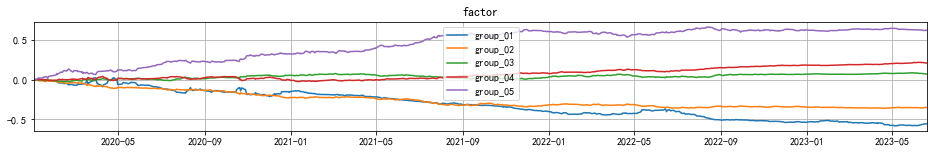

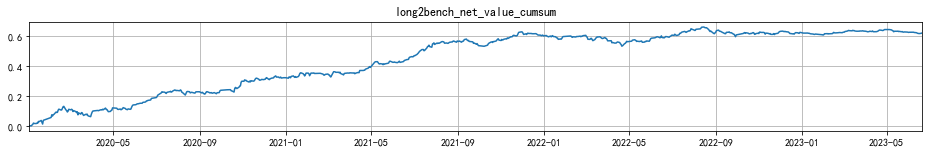

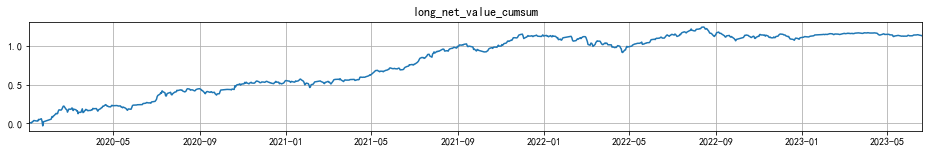

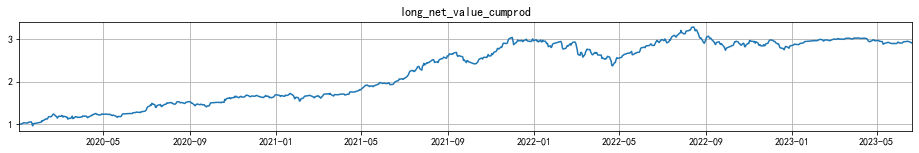

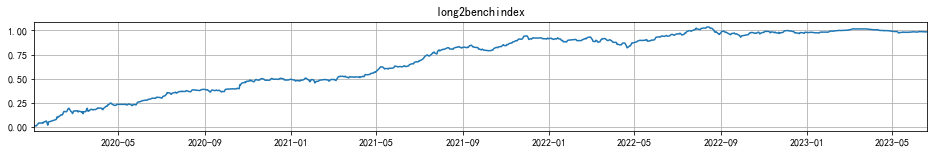

In [85]:
# xgboost回归--y预测5天,zscore,'learning_rate': [0.02,0.025,0.04,0.05],
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=0,index_pool='ZZZZ',start_date='20200103',end_date='20230620',factor_name='try',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: try
start_date,end_date 2020-01-03 2023-06-20
2020-01-03
2021-01-14
2022-01-25
2023-02-10


,turnover,gross,net
group_01,0.129950,-0.000689,-0.000871
group_02,0.197555,-0.000344,-0.000620
group_03,0.248091,0.000022,-0.000325
group_04,0.227079,0.000254,-0.000064
group_05,0.138803,0.000757,0.000563


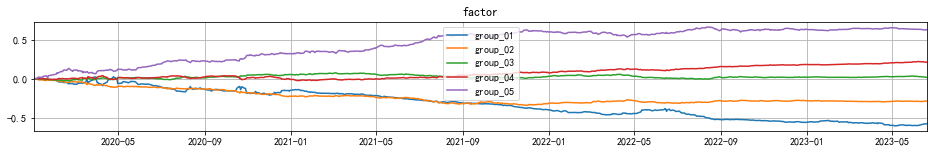

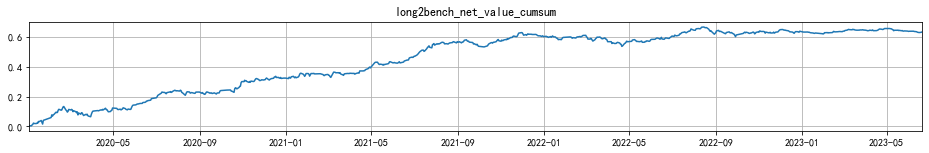

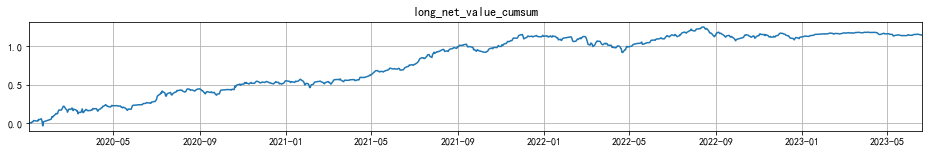

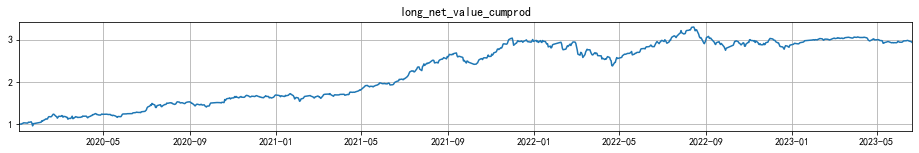

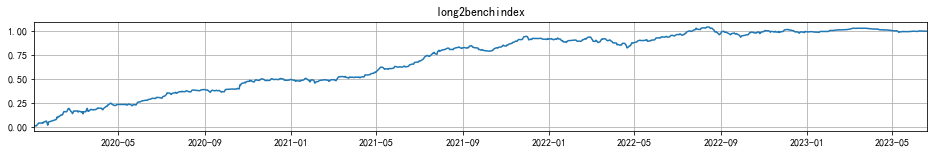

In [78]:
# xgboost回归--y预测5天,zscore,'learning_rate': [0.01,0.025,0.04]
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=0,index_pool='ZZZZ',start_date='20200103',end_date='20230620',factor_name='try',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: try
start_date,end_date 2020-01-03 2023-06-20
2020-01-03
2021-01-14
2022-01-25
2023-02-10


,turnover,gross,net
group_01,0.105163,-0.000688,-0.000835
group_02,0.176604,-0.000315,-0.000563
group_03,0.210435,0.000120,-0.000175
group_04,0.186058,0.000135,-0.000125
group_05,0.121747,0.000748,0.000578


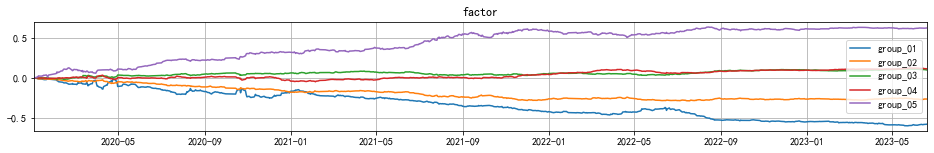

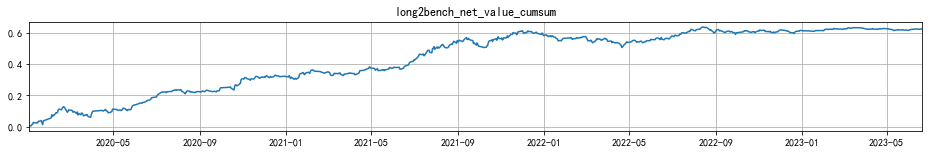

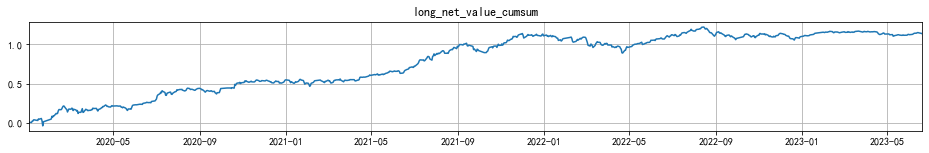

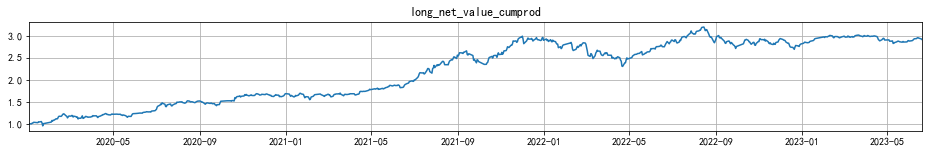

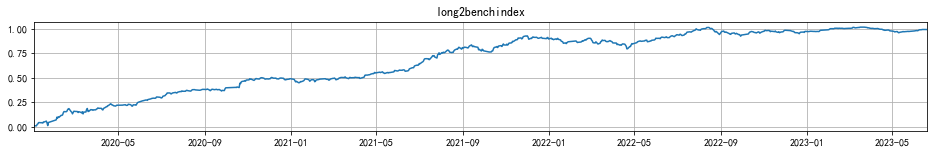

In [127]:
# xgboost回归--y预测5天,zscore,新因子，'learning_rate': [0.01,0.025,0.04]
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=0,index_pool='ZZZZ',start_date='20200103',end_date='20230620',factor_name='try',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

#### xgboost--排名打分

factor_name: try
start_date,end_date 2020-01-03 2023-06-20
2020-01-03
2021-01-14
2022-01-25
2023-02-10


,turnover,gross,net
group_01,0.166965,-0.000593,-0.000827
group_02,0.319219,-0.000300,-0.000747
group_03,0.360914,0.000103,-0.000403
group_04,0.330253,0.000156,-0.000306
group_05,0.168414,0.000634,0.000398


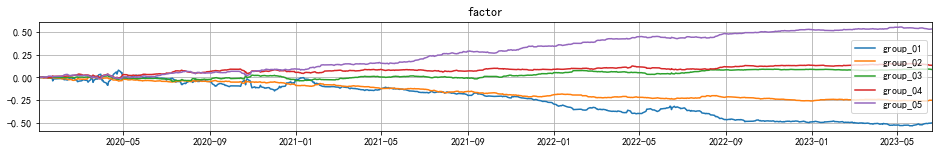

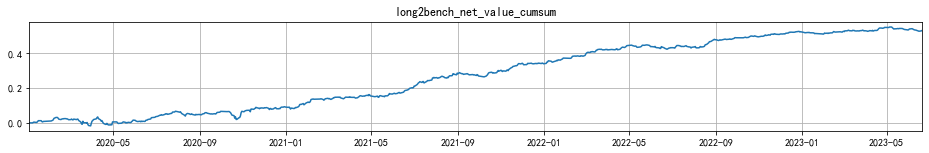

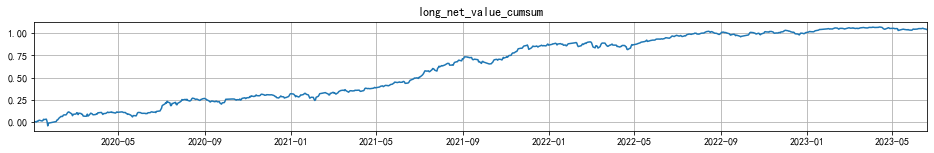

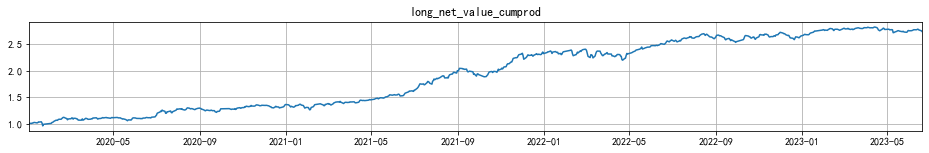

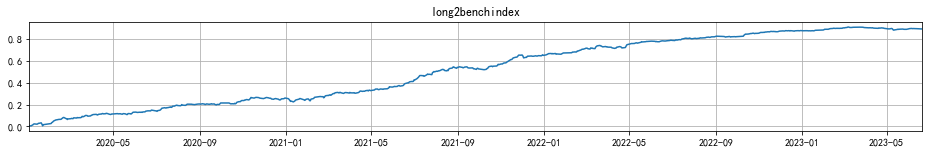

In [92]:
# 打分-xgboost回归--y预测5天，打分，'learning_rate': [0.01,0.025,0.04]
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=0,index_pool='ZZZZ',start_date='20200103',end_date='20230620',factor_name='try',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: try
start_date,end_date 2020-01-03 2023-06-20
2020-01-03
2021-01-14
2022-01-25
2023-02-10


,turnover,gross,net
group_01,0.141409,-0.000587,-0.000785
group_02,0.264205,-0.000065,-0.000435
group_03,0.306043,-0.000002,-0.000431
group_04,0.285554,0.000111,-0.000289
group_05,0.153772,0.000543,0.000327


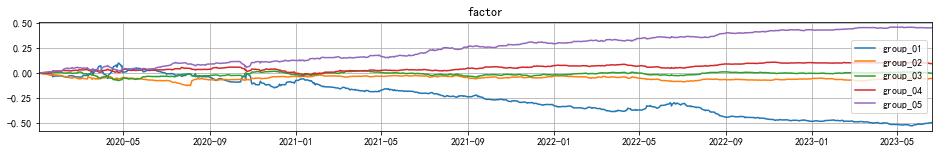

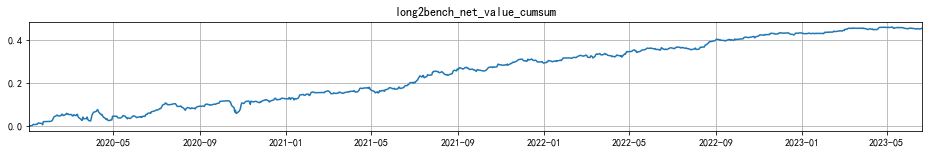

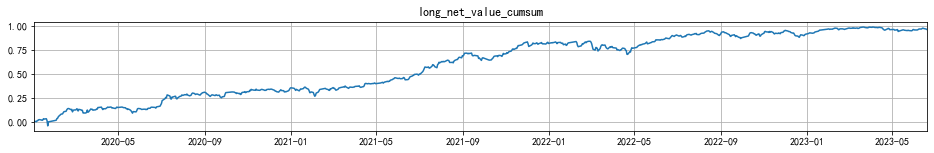

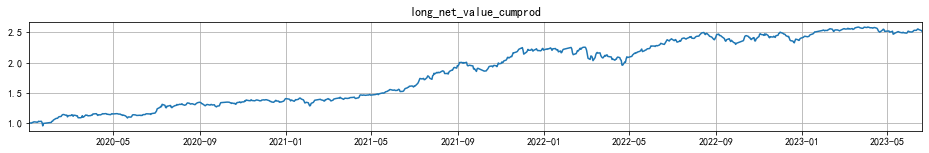

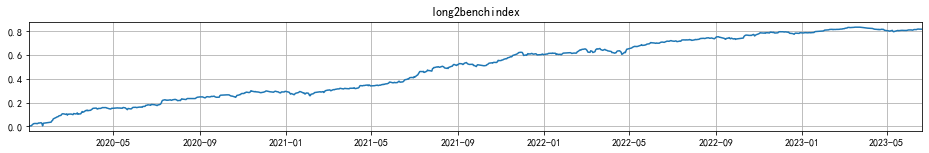

In [122]:
# 打分-xgboost回归--y预测5天,打分,新因子，'learning_rate': [0.01,0.025,0.04]
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=0,index_pool='ZZZZ',start_date='20200103',end_date='20230620',factor_name='try',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: try
start_date,end_date 2020-01-03 2023-06-20
2020-01-03
2021-01-14
2022-01-25
2023-02-10


,turnover,gross,net
group_01,0.129950,-0.000689,-0.000871
group_02,0.197555,-0.000344,-0.000620
group_03,0.248091,0.000022,-0.000325
group_04,0.227079,0.000254,-0.000064
group_05,0.138803,0.000757,0.000563


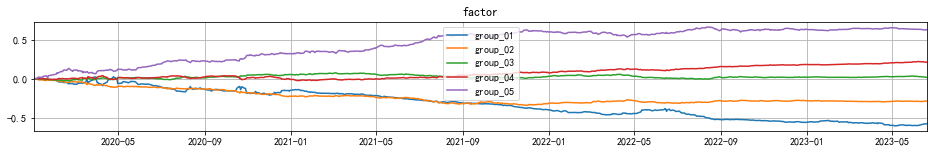

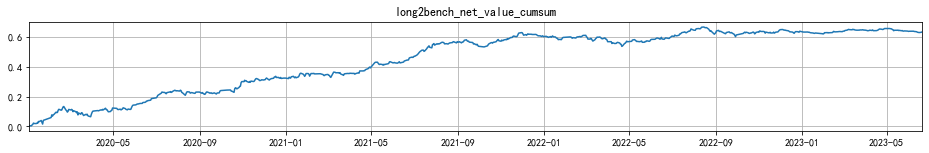

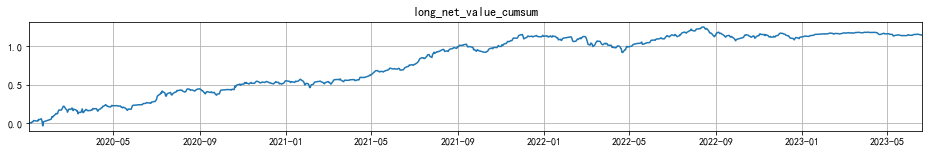

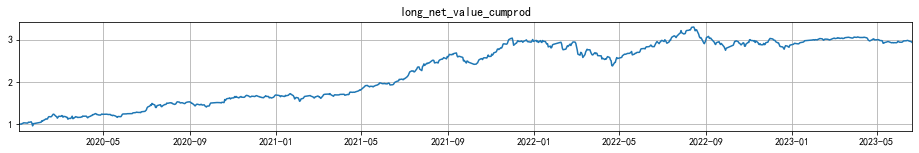

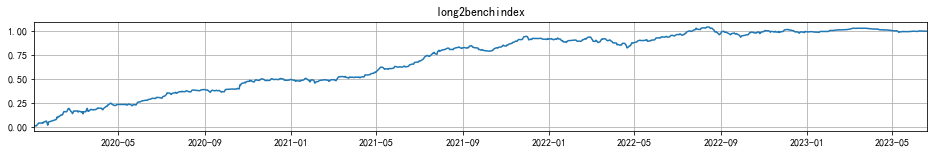

In [100]:
# 打分-xgboost回归--y预测10天，打分，'learning_rate': [0.01,0.025,0.04]
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=0,index_pool='ZZZZ',start_date='20200103',end_date='20230620',factor_name='try',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

In [ ]:
## 不运行
selected_factors = [factor_ret60,factor_stock_std,factor_deviation_BS,factor_stock_mean40,factor_dif_amplitude,
                    factor_dual_low,df_ccb_close, df_BS_iv, df_BS_iv_bias, df_ccb_outstanding_balance, df_ccb_turn,
                    df_ccb_convpremium_ratio,df_stock_mv,df_ccb_ret]

# ,df_stock_roe,df_stock_corr,df_stock_beta
factor_names_all = ['factor_ret60','factor_stock_std','factor_deviation_BS','factor_stock_mean40','factor_dif_amplitude',
                    'factor_dual_low', 'df_ccb_close', 'df_BS_iv', 'df_BS_iv_bias', 'df_ccb_outstanding_balance', 'df_ccb_turn',
                    'df_ccb_convpremium_ratio', 'df_stock_mv', 'df_ccb_ret']
# , 'df_stock_roe', 'df_stock_corr', 'df_stock_beta'


chen_factors=[-factor_dual_low,-df_ccb_close, -df_BS_iv, -df_BS_iv_bias, -df_ccb_outstanding_balance, df_ccb_turn,
              -df_ccb_convpremium_ratio,-df_stock_mv,df_stock_roe,df_stock_corr,df_stock_beta,5*df_stock_dl1,5*df_stock_dl2]
selected_factors=[factor_ret60,factor_stock_std,factor_deviation_BS,factor_stock_mean40,factor_dif_amplitude,-factor_dual_low,
                  -df_ccb_convpremium_ratio,-df_stock_mv,df_stock_roe,df_stock_corr,df_stock_beta,df_stock_dl1,df_stock_dl2]
